# GAN Latent space semantic exploration

Here we explores gan latent space showing its ability to develop semantic meanings accross pixels. This notebook does'nt contain code to train DCGAN rather we use a pretrained model which is trained CelebA dataset to generate face images. download : https://drive.google.com/file/d/1d9ILXCvSZUPGz3RQG1gTjIjbgrJ8NwuS/view?usp=sharing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_vector_size=100, feature_map_size=64, output_channel=3):
        super().__init__()

        # Input is the latent vector Z.
        self.tconv1 = nn.ConvTranspose2d(latent_vector_size, feature_map_size*8,
            kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(feature_map_size*8)

        # Input Dimension: (ngf*8) x 4 x 4
        self.tconv2 = nn.ConvTranspose2d(feature_map_size*8, feature_map_size*4,
            4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(feature_map_size*4)

        # Input Dimension: (ngf*4) x 8 x 8
        self.tconv3 = nn.ConvTranspose2d(feature_map_size*4, feature_map_size*2,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(feature_map_size*2)

        # Input Dimension: (ngf*2) x 16 x 16
        self.tconv4 = nn.ConvTranspose2d(feature_map_size*2, feature_map_size,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(feature_map_size)

        # Input Dimension: (ngf) * 32 * 32
        self.tconv5 = nn.ConvTranspose2d(feature_map_size, output_channel,
            4, 2, 1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))

        x = F.tanh(self.tconv5(x))

        return x

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls -lh /content/drive/MyDrive/models/

total 73M
-rw------- 1 root root 73M Oct  6 16:46 dcgan_generator.pth


In [6]:
# Load the checkpoint file.
model_path = "/content/drive/MyDrive/models/dcgan_generator.pth"
state_dict = torch.load(model_path)

# Set the device to run on: GPU or CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")

In [8]:
model = Generator().to(device)
model.load_state_dict(state_dict['generator'])
model.eval()

Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

In [9]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

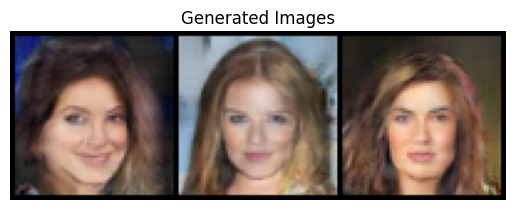

In [48]:
batch_size = 3
latent_vector_size = 100

noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

# Turn off gradient calculation to speed up the process.
with torch.no_grad():
	# Get generated image from the noise vector using
	# the trained generator.
    generated_img = model(noise).detach().cpu()

# Display the generated image.
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0)))

plt.show()

In [13]:
def generate_image(noise):
  # Turn off gradient calculation to speed up the process.
  with torch.no_grad():
    # Get generated image from the noise vector using
    # the trained generator.
      generated_img = model(noise).detach().cpu()

  # Display the generated image.
  plt.axis("off")
  plt.title("Generated Images")
  plt.imshow(np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0)))

  plt.show()

## Latent space semantic exploration

In [12]:
noise.shape

torch.Size([3, 100, 1, 1])

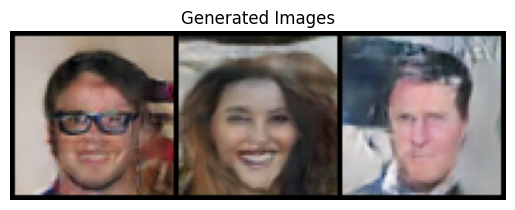

In [54]:
noise1 = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
generate_image(noise1)

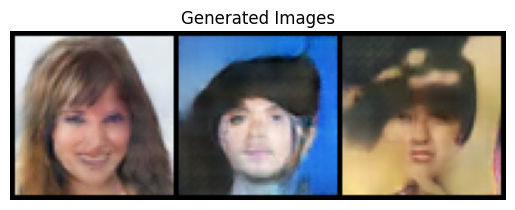

In [59]:
noise2 = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
generate_image(noise2)

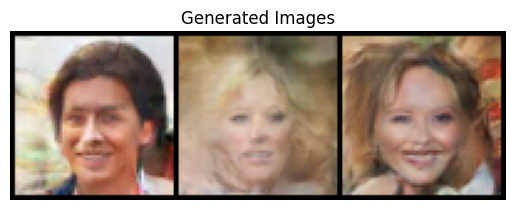

In [64]:
noise3 = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
generate_image(noise3)

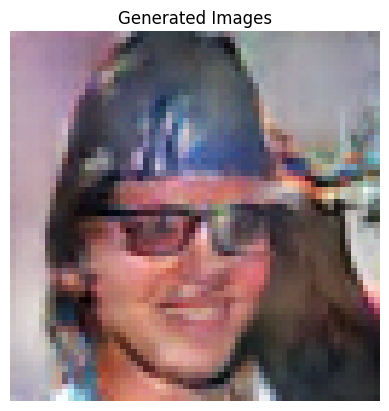

In [65]:
men_with_glass = noise1[0]
women_without_glass = noise2[0]
men_without_glass = noise3[0]

women_with_glass = men_with_glass - men_without_glass + women_without_glass
women_with_glass = women_with_glass.unsqueeze(0)  # shape now (1, 100, 1, 1)
generate_image(women_with_glass)

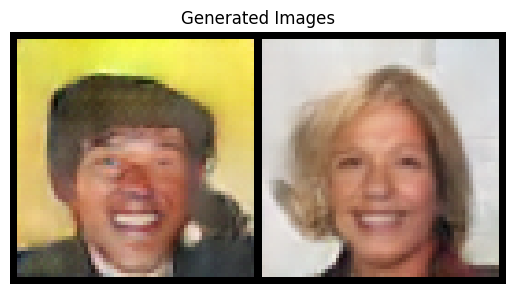

In [67]:
noise4 = torch.randn(2, latent_vector_size, 1, 1, device=device)
generate_image(noise4)

In [68]:
def get_vectors_between_noises(no_vector, noise1, noise2):
  # Create interpolation factors from 0 → 1 on same device
  alphas = torch.linspace(0, 1, no_vector, device=noise1.device).view(-1, 1, 1, 1)

  # Interpolated noise vectors (10 x 100 x 1 x 1)
  interpolated = (1 - alphas) * noise1 + alphas * noise2

  return interpolated

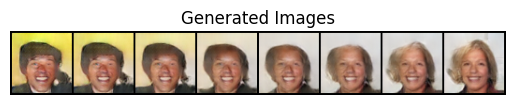

In [71]:
vectors = get_vectors_between_noises(8, noise4[0], noise4[1])
generate_image(vectors)